---
# **0. Install Library**
---

In [1]:
!pip install pyldavis
!pip install -U gensim
!pip install contextualized-topic-models==2.2.0
!pip install -U sentence-transformers
!pip install tomotopy

# konlpy, Mecab 설치 및 로드
# Reference: https://teddylee777.github.io/colab/colab-mecab
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=f97ab8f68b56e9842d8c97d1e1290668e555b3bc16ce0048d908a8a60b225dc1
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyldavis
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 70.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 5.7 MB/s 
--2022-06-09 16:22:11--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-06-09 16:22:11--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1fb566c66e02228181d1aa7cc2.dl.dropboxusercontent.com/cd/0/get/Bm4NWArOOIUFqODsCQ_lWNtESOMyPSlYbNoGFas2v67_n5Fu-vYkOotAEW-m

---
# **1. Import Library**
---

In [2]:
# .py 파일 경로 설정
%cd /content/drive/MyDrive/final-project/code

/content/drive/MyDrive/final-project/code


In [3]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import pyLDAvis
from sentence_transformers import SentenceTransformer
import keyword_modeling


np.random.seed(100)

# Custom module function
coherence_function = keyword_modeling.coherence_function
perplexity_function = keyword_modeling.perplexity_function
LSA = keyword_modeling.keyword_LSA
LDA1 = keyword_modeling.keyword_LDA1
LDA1_many = keyword_modeling.LDA1_many
LDA2 = keyword_modeling.keyword_LDA2
keybert = keyword_modeling.keyword_keybert
keywordCTM = keyword_modeling.keyword_CTM
LDA_tp = keyword_modeling.LDA_tomoto

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specif

---
# **2. Data Load**
---

In [4]:
# 영화 장르 선택
genre = '드라마'
file_path = '/content/drive/MyDrive/final-project/processed_data/data/'
file_name = f'preprocessing_{genre}_0513.pkl'

with open (file_path + file_name, 'rb') as f:
    df = pickle.load(f)

# 데이터 분리(Total, Positive, Negative)
df_total = df['Review'].tolist()
df_positive = df[df['sentiment']==1]['Review'].tolist()
df_negative = df[df['sentiment']==0]['Review'].tolist()

# 메모리 한계로 리뷰 갯수 제한
max_review = 70000  
if len(df_total) > max_review:
    df_total = df['Review'].sample(max_review).tolist() 
if len(df_positive) > max_review:
    df_positive = df[df['sentiment']==1]['Review'].sample(max_review).tolist()
if len(df_negative) > max_review:
    df_negative = df[df['sentiment']==0]['Review'].sample(max_review).tolist()

In [ ]:
print(len(df))
len(df_total), len(df_positive), len(df_negative)

24025


(24025, 17419, 2900)

---
# **3. Coherence & Perplexity**
---
 - LSA, LDA 모델의 최적 토픽 수 결정
 - Coherence 점수가 높을수록, Perplexity점수가 낮을수록 좋은 모델

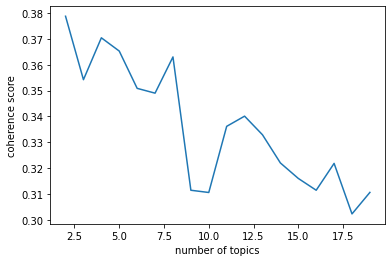

In [ ]:
max_topic = 20
top_n = 10
coherence_total = coherence_function(df_total, max_topic, top_n)
x = range(2, max_topic)
plt.plot(x, coherence_total)
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.show()

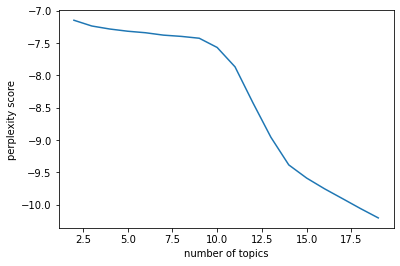

In [ ]:
perplexity_total = perplexity_function(df_total, max_topic)
x = range(2, max_topic)
plt.plot(x, perplexity_total)
plt.xlabel('number of topics')
plt.ylabel('perplexity score')
plt.show()

---
# **4. Modeling**
---
 - ``Topic Model``
    - 문서 집합에서 "토픽"이라는 추상적인 주제를 찾기 위한 통계적 모델

## **4.1 LSA**

In [ ]:
n_topics = 10
max_feature = n_topics * 100
n_words = 10

In [ ]:
df = df_total
topics_LSA_total = LSA(df, max_feature, n_topics, n_words)

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

In [ ]:
df = df_positive
topics_LSA_positive = LSA(df, max_feature, n_topics, n_words)

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

In [ ]:
df = df_negative
topics_LSA_negative = LSA(df, max_feature, n_topics, n_words)

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

## **4-2 LDA**

### **1) LDA1 gensim**


In [25]:
# 토픽수, 토픽 내 단어 수, 반복 횟수
n_topics = 10
n_words = 10
passes = 10

In [26]:
df = df_total
dic_below = int(len(df_total)*0.0001)
topics_LDA1_total, vis_LDA1_total = LDA1(df, dic_below, n_topics, n_words, passes)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [27]:
pyLDAvis.display(vis_LDA1_total)

In [ ]:
temp = [5, 10, 15]
for i in temp:
    topics_LDA1_total, vis_LDA1_total = LDA1(df, dic_below, i, n_words, passes)
    print(pyLDAvis.display(vis_LDA1_total))

In [ ]:
df = df_positive
dic_below = int(len(df_positive)*0.0001)
topics_LDA1_positive, vis_LDA1_positive = LDA1(df, dic_below, n_topics, n_words, passes)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
df = df_negative
dic_below = int(len(df_negative)*0.0001)
topics_LDA1_negative, vis_LDA1_negative = LDA1(df, dic_below, n_topics, n_words, passes)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


### **2) LDA1 gensim many**

In [ ]:
# n_topics = 8
# n_words = 10
# passes = 10
# n_random = 10

In [ ]:
# sentiment = 100
# dic_below = int(len(df_total)*0.0001)
# df = df_total
# topics_LDA1_total_many = LDA1_many(sentiment, df, dic_below,
#                                      n_topics, n_words, passes, n_random)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=Fal

In [ ]:
# sentiment = 1
# df = df_positive
# dic_below = int(len(df_positive)*0.0001)
# topics_LDA1_positive_many = LDA1_many(sentiment, df, dic_below,
#                                      n_topics, n_words, passes, n_random)  

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=Fal

In [ ]:
# sentiment = 0
# df = df_negative
# dic_below = int(len(df_negative)*0.0001)
# topics_LDA1_negative_many = LDA1_many(sentiment, df, dic_below,
#                                      n_topics, n_words, passes, n_random)  

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=Fal

### **3) LDA2 sklearn**

In [ ]:
# 단어 수, 토픽 수, 토픽 내 단어 수
max_feature = n_topics * 100
n_topics = 10
n_words = 10

In [ ]:
df = df_total
topics_LDA2_total = LDA2(df, max_feature, n_topics, n_words)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df = df_positive
topics_LDA2_positive = LDA2(df, max_feature, n_topics, n_words)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df = df_negative
topics_LDA2_negative = LDA2(df, max_feature, n_topics, n_words)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### **4) LDA tomotopy many**


In [ ]:
# 토픽 수, 훈련 횟수, 모델 갯수, 토픽 내 단어 수 
n_topics = 10
n_trains = 400
n_model = 10
top_n = 10

In [ ]:
df = df_total
topics_LDA_tp_total_many = LDA_tp(df, n_topics, n_trains, n_model, top_n)

In [ ]:
df = df_positive
topics_LDA_tp_positive_many = LDA_tp(df, n_topics, n_trains, n_model, top_n)

In [ ]:
df = df_negative
topics_LDA_tp_negative_many = LDA_tp(df, n_topics, n_trains, n_model, top_n)

## **4.3 KeyBERT**

In [ ]:
# 문장과 코사인 유사도 가까운 단어 갯수
top_n = 3

In [ ]:
df = df_total
keybert_total = keybert(df, top_n)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


  0%|          | 0/72074 [00:00<?, ?it/s]

In [ ]:
df = df_positive
keybert_positive = keybert(df, top_n)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


  0%|          | 0/52256 [00:00<?, ?it/s]

In [ ]:
df = df_negative
keybert_negative = keybert(df, top_n)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


  0%|          | 0/8699 [00:00<?, ?it/s]

## **4.4 CTM (Combined Topic Model)**

In [ ]:
# 오류 메시지 제거
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
n_topics = 30
max_feature = n_topics * 50
num_epochs = 20

In [ ]:
df = df_total
CTM_total, vis_CTM_total = keywordCTM(df, max_feature, n_topics, num_epochs)
ctm_pd_total = pyLDAvis.prepare(**vis_CTM_total)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Epoch: [20/20]	 Seen Samples: [480500/480500]	Train Loss: 34.20444674838222	Time: 0:00:07.003962: : 20it [02:27,  7.35s/it]
Sampling: [10/10]: : 10it [01:00,  6.05s/it]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
df = df_positive
CTM_positive, vis_CTM_positive = keywordCTM(df, max_feature, n_topics, num_epochs)
ctm_pd_positive = pyLDAvis.prepare(**vis_CTM_positive)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Batches:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: [20/20]	 Seen Samples: [348380/348380]	Train Loss: 35.130801018606995	Time: 0:00:05.123712: : 20it [01:43,  5.18s/it]
Sampling: [10/10]: : 10it [00:45,  4.54s/it]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
df = df_negative
CTM_negative, vis_CTM_negative = keywordCTM(df, max_feature, n_topics, num_epochs)
ctm_pd_negative = pyLDAvis.prepare(**vis_CTM_negative)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: [20/20]	 Seen Samples: [58000/58000]	Train Loss: 35.74636175747575	Time: 0:00:01.219323: : 20it [00:24,  1.22s/it]
Sampling: [10/10]: : 10it [00:10,  1.08s/it]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


---
# **5. Data save**
---

In [ ]:
file_path = f'/content/drive/MyDrive/final-project/processed_data/result/{genre}/'

In [ ]:
# Coherence & Perplexity
file_name = f'{genre}_coherence_perplexity.pkl'
with open (file_path + file_name, 'wb') as f:
    pickle.dump((coherence_total, perplexity_total),f)

In [ ]:
# LSA
file_name = f'{genre}_LSA.pkl'
with open (file_path+file_name, 'wb') as f:
    pickle.dump((topics_LSA_total, topics_LSA_positive, topics_LSA_negative), f)

In [ ]:
# LDA1
file_name = f'{genre}_LDA1.pkl'
with open (file_path + file_name, 'wb') as f:
    pickle.dump((topics_LDA1_total, vis_LDA1_total,
                 topics_LDA1_positive, vis_LDA1_positive,
                 topics_LDA1_negative, vis_LDA1_negative), f)    

In [ ]:
# LDA2
file_name = f'{genre}_LDA2.pkl'
with open (file_path+file_name, 'wb') as f:
    pickle.dump((topics_LDA2_total, topics_LDA2_positive, topics_LDA2_negative), f)

In [ ]:
# LDA_tp
file_name = f'{genre}_LDA_tp_many_{n_model}.pkl'
with open (file_path + file_name, 'wb') as f:
    pickle.dump((topics_LDA_tp_total_many,
                 topics_LDA_tp_positive_many,
                 topics_LDA_tp_negative_many), f)  
    

In [ ]:
# keybert
file_name = f'{genre}_keybert_{top_n}.pkl'
with open (file_path+file_name, 'wb') as f:
    pickle.dump((keybert_total, keybert_positive, keybert_negative), f)

In [ ]:
# CTM
file_name = f'{genre}_CTM.pkl'
with open (file_path+file_name, 'wb') as f:
    pickle.dump((CTM_total.get_topics(100), ctm_pd_total,
                 CTM_positive.get_topics(100), ctm_pd_positive,
                 CTM_negative.get_topics(100), ctm_pd_negative), f)